# Data

We use real data compiled by Amadeus, made available as part of the [ROADEF 2009 Challenge: Disruption Management for Commercial Aviation](https://www.roadef.org/challenge/2009/en/). This dataset is based on flight plans for an airline in France. For this notebook, we have pre-processed this dataset and stored the information in three parts:

- Current flight plan: The currently planned set of flights and their aircraft assignments assuming that there is no weather disruption (i.e., all airports operate at full capacity).
- Aircraft starting and ending positions: Where should each aircraft start the day and end the day? This information is necessary to ensure that aircrafts are where they need to be for the next day so that the disruption does not extend into the next day.
- Passenger itinerary: The number of passengers and the price per ticket sold for each flight. This information is useful to assess the revenue brought in by each flight.

Note that even though the data used in this example is from 2006, the optimization model is ambivalent of the data. For any new flight plan and predicted future disruption levels, the model will optimally solve the routing and flight service decisions.

In [212]:
# %pip install networkx matplotlib seaborn plotly-express
import pandas as pd    
import matplotlib.pyplot as plt  
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import random


In [213]:
df_current_plan = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/aviation_planning/data/flight_rotations_2006-07-01.csv') 
# if you run this notebook locally, you can also use
#df_current_plan = pd.read_csv('data/flight_rotations_2006-07-01.csv') 

df_current_plan['start_time'] = pd.to_datetime(df_current_plan['start_time'], format='%H:%M')
df_current_plan['start_time'] = df_current_plan['start_time'].dt.time
df_current_plan['end_time'] = pd.to_datetime(df_current_plan['end_time'], format='%H:%M')
df_current_plan['end_time'] = df_current_plan['end_time'].dt.time
df_current_plan['duration'] = pd.to_datetime(df_current_plan['duration'], format='%H:%M')
df_current_plan['duration'] = df_current_plan['duration'].dt.time
df_current_plan

,flight,date,aircraft,ori,des,start_time,end_time,duration
0,1,7/1/06,TranspCom#1,CDG,ORY,00:00:00,00:30:00,00:30:00
1,73,7/1/06,TranspCom#3,ORY,CDG,00:00:00,00:30:00,00:30:00
2,2,7/1/06,TranspCom#2,CDG,ORY,00:20:00,00:50:00,00:30:00
3,74,7/1/06,TranspCom#4,ORY,CDG,00:20:00,00:50:00,00:30:00
4,75,7/1/06,TranspCom#1,ORY,CDG,00:40:00,01:10:00,00:30:00
...,...,...,...,...,...,...,...,...
603,142,7/1/06,TranspCom#4,ORY,CDG,23:00:00,23:30:00,00:30:00
604,143,7/1/06,TranspCom#1,ORY,CDG,23:20:00,23:50:00,00:30:00
605,71,7/1/06,TranspCom#3,CDG,ORY,23:20:00,23:50:00,00:30:00
606,144,7/1/06,TranspCom#2,ORY,CDG,23:40:00,00:10:00,00:30:00


In [214]:
flights = df_current_plan['flight'].unique()
aircrafts = df_current_plan['aircraft'].unique()
airports = set(df_current_plan['ori'].unique() + df_current_plan['des'].unique())

print(len(flights),"flights between",len(airports),"airports operated with",len(aircrafts),"aircrafts")

608 flights between 35 airports operated with 85 aircrafts


# Visualizing the network

Next, we assemble the origin-destination airports for all the flights, and visualize the entire network of planned flights. We use networkx to store the inter-airport information as a directed graph data structure to enable this visualization.

Moreover, to reduce the size of the inputs, we can select just the top few airports (in terms of how many flights flow through them) for the rest of the notebook. The n_airports parameter selects the number of top airports to pre-select, with default set to 20 airports.

The visual below is intended to illustrate the complexity of the flight map; do not feel like you need to spend too much time analyzing it. We will drill down into specific flight paths later.

In [215]:
from IPython.display import Image, display
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 
 
arcs = list(df_current_plan[['ori','des']].itertuples(index=False, name=None)) # store the origin-destination pairs of all the flights

n_airports = 4 # specify how many airports to pick
    
G = nx.MultiDiGraph() # create an empty directed graph
G.add_edges_from(arcs) # add the origin-destination pairs to the graph as directed edges

top_airports = [i for (i,j) in sorted(G.degree, key=lambda x: x[1], reverse=True)[:n_airports]] # pre-select top airports by their degree

G = G.subgraph(top_airports) # reduce the graph to just the top few airports
 
# reduce the current plan dataframe to just the top few airports    
df_current_plan = df_current_plan[df_current_plan['ori'].isin(top_airports)] 
df_current_plan = df_current_plan[df_current_plan['des'].isin(top_airports)]

# # visualize the network
# A_graph = to_agraph(G) 
# A_graph.layout('dot')    
# display(A_graph) 
 

flights = df_current_plan['flight'].unique()
aircrafts = df_current_plan['aircraft'].unique()
airports = set(df_current_plan['ori'].unique()+df_current_plan['des'].unique())

print("The reduced data has",len(flights),"flights between",len(airports),"airports operated with",len(aircrafts),"aircrafts")


The reduced data has 222 flights between 4 airports operated with 21 aircrafts


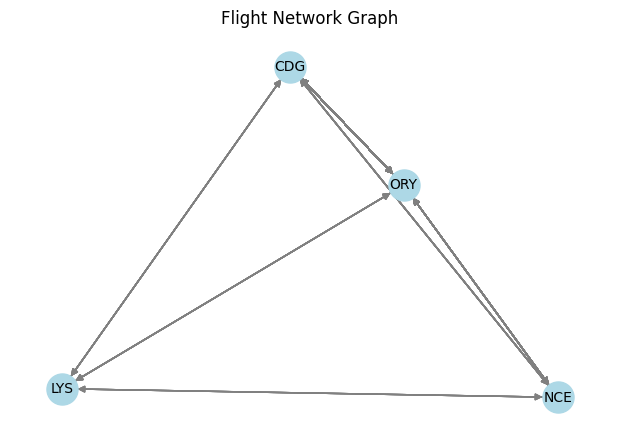

In [216]:
plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Flight Network Graph")
plt.show()

# Where should the aircrafts start and end the day?
At the start of the disruption day, each aircraft starts from a particular airport, and must end the day at a particular airport. This is to ensure that the aircraft fleet is ready and available for uninterrupted flight operations for the next day.

We now read the information on the aircraft fleet's starting position (called the source) and ending position (called the sink). 

In [217]:

flight_origin = df_current_plan.set_index('flight')['ori'].to_dict()
flight_dest = df_current_plan.set_index('flight')['des'].to_dict()
flight_start_time = df_current_plan.set_index('flight')['start_time'].to_dict()
flight_end_time = df_current_plan.set_index('flight')['end_time'].to_dict() 


In [218]:
df_starting_positions = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/aviation_planning/data/starting_positions.csv')  
# if you run this notebook locally, you can also use
#df_starting_positions = pd.read_csv('data/starting_positions.csv')  
aircrafts_startpositions_airc = df_starting_positions.set_index('aircraft')['airport'].to_dict()

df_ending_positions = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/aviation_planning/data/ending_positions.csv')
# if you run this notebook locally, you can also use
#df_ending_positions = pd.read_csv('data/ending_positions.csv')
aircrafts_endpositions_airc = df_ending_positions.set_index('aircraft')['airport'].to_dict()


In [219]:
df_starting_positions

,aircraft,airport
0,TranspCom#3,ORY
1,TranspCom#1,CDG
2,TranspCom#4,ORY
3,TranspCom#2,CDG
4,ERJ135#2,LEH
...,...,...
80,A319#12,ORY
81,A321#5,MPL
82,CRJ100#1,TLS
83,A319#9,ORY


In [220]:
df_ending_positions

,aircraft,airport
0,TranspCom#3,ORY
1,TranspCom#1,CDG
2,TranspCom#2,ORY
3,TranspCom#4,CDG
4,CRJ700#1,TLS
...,...,...
80,BAE300#2,LRT
81,ERJ135#1,ORY
82,BAE300#1,LIG
83,ERJ145#1,AVN


# Passenger Itineraries
Next, we read the passenger itinerary data. For each flight, we know how many passengers booked the tickets and the cost of each seat. We will store this information in dictionaries so that we can later assess the cost of cancelling a flight.

In [221]:
df_iterinaries = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/aviation_planning/data/flight_iterinaries.csv')
#df_iterinaries = pd.read_csv('data/flight_iterinaries.csv')
df_iterinaries['total_cost'] = df_iterinaries['cost'] * df_iterinaries['n_pass']
flight_revenue = df_iterinaries.groupby(['flight'])['total_cost'].agg('sum').to_dict() 
flight_n_pass = df_iterinaries.groupby(['flight'])['n_pass'].agg('sum').to_dict()

df_iterinaries


,cost,n_pass,flight,total_cost
0,137.5,24.0,4296.0,3300.0
1,137.5,33.0,4296.0,4537.5
2,137.5,24.0,4296.0,3300.0
3,137.5,44.0,4296.0,6050.0
4,137.5,35.0,4295.0,4812.5
...,...,...,...,...
1925,200.0,15.0,2620.0,3000.0
1926,250.0,6.0,2609.0,1500.0
1927,250.0,4.0,2609.0,1000.0
1928,325.0,16.0,5125.0,5200.0


# Create flight-to-flight transitions for each aircraft

Finally, using the current flight plan, we assess all the feasible flight-to-flight transitions. Such a transition is  essentially: after each flight, what is the next possible flight?

For two flights $f_1$ and $f_2$, the flight transition $f_1$-$f_2$ is *feasible* if the arrival time of $f_1$ is before the departure time of $f_2$, and the destination of $f_1$ is the same as the origin of $f_2$.

Based on these feasible transitions, each aircraft's route is a sequence of flight-to-flight transitions starting from the source airport to its sink airport.


For example, from the data, the aircraft A380#1 (which is an Airbus 380) starts the day at airport CFE. From here, it can either take flight 4296 (CFE-ORY) at 5:40am or flight 4298 (CFE-ORY) at 10:48am. Once it gets to ORY, it will have multiple options for the rest of the day's route. In total,  A380#1 has eight flight paths (see visualization below).

To compactly store all the feasible flight-to-flight transitions, we create a **directed acyclic graph** (DAG). The vertices are the flights, and the directed edges are feasible transitions. Use the interactive tool below to visualize the DAG for each aircraft.

In [222]:
# %pip install ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual

aircraft_flights = df_current_plan.groupby(['aircraft']).apply(lambda x: x['flight'].tolist()).to_dict()
flight_arcs_for_each_aircraft = {}
deltaplus_flightarcs = {}
deltaminus_flightarcs = {}
for a in aircraft_flights:
    print(aircraft_flights)
    print(a)
    aircraft_flights[a] += ['source_%s'%a,'sink_%s'%a]
    flight_origin['source_%s'%a] = aircrafts_startpositions_airc[a]
    flight_dest['source_%s'%a] = aircrafts_endpositions_airc[a]
    flight_origin['sink_%s'%a] = aircrafts_endpositions_airc[a]
    flight_dest['sink_%s'%a] = aircrafts_startpositions_airc[a]

    flight_start_time['source_%s'%a] = datetime.strptime('0:0', '%H:%M').time()
    flight_end_time['source_%s'%a] = datetime.strptime('0:0', '%H:%M').time()

    flight_start_time['sink_%s'%a] = datetime.strptime('23:59', '%H:%M').time()
    flight_end_time['sink_%s'%a] = datetime.strptime('23:59', '%H:%M').time()

    flight_arcs_for_each_aircraft[a] = []
    deltaplus_flightarcs[a] = {f: [] for f in aircraft_flights[a]}
    deltaminus_flightarcs[a] = {f: [] for f in aircraft_flights[a]}

    for f1 in aircraft_flights[a]:
        for f2 in aircraft_flights[a]:
            if f1 != f2 and flight_end_time[f1] < flight_start_time[f2] and flight_dest[f1] == flight_origin[f2]:
                flight_arcs_for_each_aircraft[a].append((f1, f2))
                deltaplus_flightarcs[a][f1].append(f2)
                deltaminus_flightarcs[a][f2].append(f1) 


{'A318#4': [3064, 3069, 3074, 3077, 3082, 3085, 3092, 3095], 'A318#5': [3065, 3070, 3075, 3080, 3083, 3090, 3093], 'A318#7': [4515, 4506], 'A318#8': [3103, 3068, 3073, 3088, 3081, 3102], 'A319#11': [3107, 3108, 3097, 3086], 'A319#13': [3067], 'A319#18': [4514, 4503, 4516, 4509, 4510, 4513], 'A319#5': [3111, 3112], 'A319#9': [3091, 3084, 3099], 'A320#11': [4269, 4270, 4271, 4276], 'A320#14': [4504, 4507, 4508, 4511], 'A320#22': [4576, 4577, 4578, 4575], 'A320#24': [4574, 4565, 4566, 4569, 3106], 'A321#2': [4264, 4265, 4268, 4273, 4272, 4279, 4274, 4275], 'A321#4': [4563, 4564, 4567, 4568, 4571, 4572], 'CRJ700#3': [3076, 3063], 'ERJ145#5': [4694, 4693, 4696, 4699, 4700, 4695], 'TranspCom#1': [1, 75, 5, 79, 9, 83, 13, 87, 17, 91, 21, 95, 25, 99, 29, 103, 33, 107, 37, 111, 41, 115, 45, 119, 49, 123, 53, 127, 57, 131, 61, 135, 65, 139, 69, 143], 'TranspCom#2': [2, 76, 6, 80, 10, 84, 14, 88, 18, 92, 22, 96, 26, 100, 30, 104, 34, 108, 38, 112, 42, 116, 46, 120, 50, 124, 54, 128, 58, 132, 62, 

In [223]:
## after installing Visual C/C++ https://pygraphviz.github.io/documentation/stable/install.html 
# !python -m pip install --use-pep517 --config-setting="--global-option=build_ext" --config-setting="--global-option=-IC:\Program Files\Graphviz\include" --config-setting="--global-option=-LC:\Program Files\Graphviz\lib" pygraphviz

In [225]:
def visualize_aircraft_network(x): 
    G = nx.DiGraph()
    G.add_edges_from(flight_arcs_for_each_aircraft[x])
    plt.figure(figsize=(20,14)) 
    A_graph = to_agraph(G) 
    A_graph.layout('dot')    
    display(A_graph)             
    plt.show()
 
# interact(visualize_aircraft_network, x=aircraft_flights.keys())

# Optimization Model



A weather disruption diminishes the overall capacity of the airports, measured by the number of flights that can take-off and land. Given this reduced airport capacity, which flights should be operated, and what route should the aircrafts take? Our goal is to create an optimal flight plan that minimizes the overall revenue loss incurred from the cancelled flights.

This decision problem is modeled using a mathematical optimization model, which finds the best solution according to an objective function such that the solution satisfies a set of constraints. Here, a solution is expressed as a vector of real values or integer values called decision variables. Constraints are a set of equations or inequalities written as a function of the decision variables.

In this airline business model, the objective is to minimize the overall loss from all the cancelled flights. The decision variables decide which flights to operate/cancel, as well as construct a route for each aircraft that starts from its starting airport and ends at the airport it needs to be at the end of the day. There are three types of constraints: 
- (i) construct the flight route 
- (ii) ensure that a flight is operated only if it is in the flight route, and 
- (iii) ensure that the number of take-offs and landings are within the diminished capacity of the airports.


# Assumptions

There are many modeling assumptions made in this notebook, as this model serves as a starting point. At the end of the notebook, we suggest potential extensions. The following are some key assumptions.

- All airports have the same level of disruption, which is across the entire day.
- Assume that we know ahead of time the level of disruption at all airports.
- Ignore crew scheduling and maintainance issues.
- No consideration of how other airlines may react to the disruption.


# Input Parameters

Let us now define the input parameters and notations used for creating the model. The subscript $a$ will be used to denote each aircraft, $f$ for each flight, and $i$ for each airport.


- $N$: set of all airports
- $A$: set of all aircrafts
- $F$: set of all flights
- $F_a$: set of flights operated by aircraft $a$ in the current plan
- $E_a$: set of feasible flight-to-flight transitions for aircraft $a$ 
- $r_f$: revenue ($\$$) from operating flight $f$
- $(o_f,d_f)$: origin, destination airports for flight $f$
- $(C^{arr}_i,C^{dep}_i)$: maximum number of arrivals and departures in airport $i$
- $\alpha$: level of disruption

The following code loads the Gurobi python package and initiates the optimization model. 
The value of $\alpha$ is set to $50\%$.

In [226]:
# %pip install gurobipy
import gurobipy as gp
from gurobipy import GRB
model = gp.Model("airline_disruption")
 
N = G.nodes() 

# Decision Variables

We now define the decision variables.
In our model, we want to do two things: pick flights to be operated by each aircraft and construct a route for each aircraft. 
The following notation is used to model these decision variables.


$x_{a,f}$: $1$, if aircraft $a$ operates flight $f$; $0$, otherwise

$y_{a,f_1,f_2}$: $1$, if aircraft $a$ operates flight $f_2$ immediately after flight $f_1$; $0$, otherwise

We will now add the variables to the Gurobi model using the addVar function.

In [227]:
x, y = {}, {}
for a in aircrafts:
    for f in aircraft_flights[a]:
        x[a,f] = model.addVar(name="x_%s,%s"%(a,f), vtype=GRB.BINARY)

    for (f1,f2) in flight_arcs_for_each_aircraft[a]:
        y[a,f1,f2] = model.addVar(name="y_%s,%s,%s"%(a,f1,f2), vtype=GRB.BINARY)

model.update()

# Define Objective Function

**Minimize the revenue from cancelled flights**

(We can change this to minimize delay)

Our goal is to **minimize** the total **lost revenue** from the cancelled flights. 
We capture this objective as a function of the decision variables.
Note that a flight is cancelled if $x_{a,f}$ is set to $0$.
The revenue lost from the flight is given by $(1-x_{a,f}) * r_f$.
Hence, the overall lost revenue across all aircrafts and cancelled flights is given by,


\begin{aligned} 
\textrm{Minimize } \ \sum_{a \in aircrafts} \ \sum_{f \in F_a} \ (1-x_{a,f}) * r_f
\end{aligned}

We now add this objective function to the model using the setObjective function.

In [228]:
objective = gp.quicksum((1-x[a,f])*flight_revenue[f] for a in aircrafts for f in aircraft_flights[a] if f in flight_revenue) # operating cost
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraint 1

**Construct each aircraft's flight path**

An aircraft begins the day from its starting airport (source) and ends the day at its final airport (sink). Its route during the day is constructed using the **y** decision variables. 

We do this by considering three cases for each aircraft: its starting flight, an intermediary flight, and its ending flight.

When a flight leaves its starting airport, we ensure that it can leave exactly once.
The flights in the set $\delta^+(source_a)$ gives the set of all candidate "first-flights" for the aircraft.
We ensure that exactly one of these flights is taken using the following equality for each aircraft $a$.

\begin{aligned} 
\sum_{f' \in \delta^+(source_a)} y_{a,source_a,f'} &= 1
\end{aligned} 

Similarly, a flight arrives at its final airport, we ensure that it enters the airport exactly once.
The flights in the set $\delta^-(sink_a)$ gives the set of all candidate "last-flights" for the aircraft, and we ensure that exactly one of these flights is taken.

\begin{aligned} 
\sum_{f' \in \delta^-(sink_a)} y_{a,f',sink_a} &= 1
\end{aligned}

For every intermediary flight $f$ in $F_a$ (that is neither the starting nor the ending flight), we ensure that the number of preceding and succeeding flights are the same. This is necessary to ensure the continuity of the flight path.
The following constraints are for each aircraft $a$ and  intermediary flight $f$ in $F_a$.

\begin{aligned} 
\sum_{f' \in \delta^+(f)} y_{a,f,f'} &= \sum_{f' \in \delta^-(i)} y_{a,f',f} 
\end{aligned}

In optimization modeling, these types of constraints are called **flow-balance** constraints.
These are used to model many famous problems such as shortest path, maximum flow problem, and the traveling salesman problem. Read more [here](https://web.mit.edu/15.053/www/AMP-Chapter-08.pdf).
The following code adds these constraints to the model one at a time.

In [229]:
for a in aircrafts:
    model.addConstr(sum(y[a,'source_%s'%a,f2] for f2 in deltaplus_flightarcs[a]['source_%s'%a]) == 1)
    model.addConstr(sum(y[a,f1,'sink_%s'%a] for f1 in deltaminus_flightarcs[a]['sink_%s'%a]) == 1)
    for f in aircraft_flights[a]:
        if str(f)[0] != 's':
            model.addConstr(sum(y[a,f,f2] for f2 in deltaplus_flightarcs[a][f]) == sum(y[a,f1,f] for f1 in deltaminus_flightarcs[a][f]))

# Constraint 2

**A flight is operated only if it is traversed by an aircraft**

Next, we make sure that a flight $f$ is operated by an aircraft $a$ only if $f$ is in the route taken by $a$.
The quantity $\sum_{f' \in \delta^+(f)} y_{a,f,f'}$ gives us the number of arcs that leave flight $f$; there can be either $0$ arcs or $1$ arc. 
If this quantity is $0$, then aircraft $f$ does not traverse flight $f$, and we set $x_{a,f}$ to be $0$.
This constraint can be mathematically expressed by the following inequality for each aircraft $a$ and flight $f$ in $F_a$

\begin{aligned}  
x_{a,f} &\leq \sum_{f'\ \textrm{in }\ \delta^+(f)} y_{a,f,f'}
\end{aligned}

Let us now add these constraints to the model.

In [230]:
for a in aircrafts:
    for f in aircraft_flights[a]:
        model.addConstr(x[a,f] <= sum(y[a,f,f2] for f2 in deltaplus_flightarcs[a][f])) # flight f is chosen only if it is traversed
        

# Constraint 3

**Maximum limit on the number of arrivals and departures from the airports**

Finally, we add the airport capacity constraints. 
For each airport, we know the total number of arrivals and departures on a regular day. 
However, on the disruption day, only a fraction of flights can land and take-off, given by the parameters $\alpha$.
For example, if $\alpha = 0.5$, only half the flights can land or take-off.
This condition can be mathematically expressed using the following inequalities for every airport $i$,

\begin{aligned} 
\sum_{\textrm{aircraft a}} \ \sum_{\textrm{flight }f \textrm{ that arrives at $i$}} x_{a,f} &\leq C^{arr}_{i} * \alpha \quad  \forall \ \textrm{airport } i, \\
\sum_{\textrm{aircraft a}} \ \sum_{\textrm{flight }f \textrm{ that departs from $i$}} x_{a,f} &\leq C^{dep}_{i} *\alpha \quad  \forall \ \textrm{airport } i.
\end{aligned}

The left hand side of the inequalities counts the total number of flights that land or take-off at the airports, and the right hand side sets the maximum limits.
As extreme cases, setting $\alpha  = 0$ implies that there is a complete shut-down of the airports, and $\alpha = 1$ implies that there is no disruption.

We can add these constraints to the model, with a default values set to $0.5$. Later in the notebook, we see how the disruption parameter affects the optimal flight plan.

In [231]:
alpha = .5 

for i in N:
    total_departures = len([f for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i])
    total_arrivals = len([f for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i])

    model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i) <= alpha*total_departures)
    model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i) <= alpha*total_arrivals)


In [232]:
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-1340P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 536 rows, 1920 columns and 5742 nonzeros
Model fingerprint: 0xf2db7e04
Variable types: 0 continuous, 1920 integer (1920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+03, 6e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 1878476.0000
Presolve removed 498 rows and 1559 columns
Presolve time: 0.02s
Presolved: 38 rows, 361 columns, 722 nonzeros
Found heuristic solution: objective 801512.00000
Variable types: 0 continuous, 361 integer (344 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 801512 1.87848e+06 

Optimal solution fou

# Optimal Solution

In [233]:
operated_flights = {a: [f for f in aircraft_flights[a] if x[a,f].X > .5 if str(f)[0] != 's'] for a in aircrafts}

total_loss = round(model.objVal/10**6,2)
reserved_flights = sum(len(operated_flights[a]) for a in aircrafts)
passengers = sum(sum(flight_n_pass[f] for f in aircraft_flights[a] if x[a,f].X > .5) for a in aircrafts)
used_aircrafts = sum([1 if len(operated_flights[a]) > 0 else 0 for a in aircrafts])

print(f"Net revenue total loss: ${total_loss} million")
print(f"Optimal number of flights served: {reserved_flights}")
print(f"Optimal number of passengers transported: {passengers}")
print(f"Optimal number of aircrafts utilized: {used_aircrafts}")


Net revenue total loss: $0.8 million
Optimal number of flights served: 50
Optimal number of passengers transported: 5641.0
Optimal number of aircrafts utilized: 10


In [234]:
operated_flights

{'TranspCom#1': [],
 'TranspCom#3': [],
 'TranspCom#2': [],
 'TranspCom#4': [],
 'A320#22': [4576, 4577, 4578, 4575],
 'ERJ145#5': [4693, 4696, 4700, 4695],
 'A321#2': [4264, 4265, 4268, 4273, 4272, 4279, 4274, 4275],
 'A318#8': [3103, 3068, 3073, 3088, 3081, 3102],
 'A318#4': [3064, 3069, 3074, 3077, 3082, 3085, 3092, 3095],
 'A321#4': [],
 'A319#18': [4514, 4503, 4516, 4509, 4510, 4513],
 'A320#24': [],
 'A319#11': [3107, 3108, 3097, 3086],
 'A318#5': [3070, 3075, 3080, 3083, 3090, 3093],
 'A319#13': [],
 'A318#7': [],
 'A320#11': [],
 'A320#14': [],
 'A319#5': [3111, 3112],
 'CRJ700#3': [3076, 3063],
 'A319#9': []}

In [235]:
import gurobipy as gp
from gurobipy import GRB
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
 
N = G.nodes() 
 
def solve_flight_planning(x):    
    alpha = x 
    
    model = gp.Model("airline_disruption")
    x, y = {}, {}
    for a in aircrafts:
        for f in aircraft_flights[a]:
            x[a,f] = model.addVar(name="x_%s,%s"%(a,f), vtype=GRB.BINARY)

        for (f1,f2) in flight_arcs_for_each_aircraft[a]:
            y[a,f1,f2] = model.addVar(name="y_%s,%s,%s"%(a,f1,f2), vtype=GRB.BINARY)

    model.update()

    objective = gp.quicksum((1-x[a,f])*flight_revenue[f] for a in aircrafts for f in aircraft_flights[a] if f in flight_revenue) # operating cost
    model.setObjective(objective, sense=GRB.MINIMIZE)

    for a in aircrafts:
        model.addConstr(sum(y[a,'source_%s'%a,f2] for f2 in deltaplus_flightarcs[a]['source_%s'%a]) == 1)
        model.addConstr(sum(y[a,f1,'sink_%s'%a] for f1 in deltaminus_flightarcs[a]['sink_%s'%a]) == 1)
        for f in aircraft_flights[a]: 
            if str(f)[0] != 's':
                model.addConstr(sum(y[a,f,f2] for f2 in deltaplus_flightarcs[a][f]) == sum(y[a,f1,f] for f1 in deltaminus_flightarcs[a][f]))

    for a in aircrafts:
        for f in aircraft_flights[a]:
            model.addConstr(x[a,f] <= sum(y[a,f,f2] for f2 in deltaplus_flightarcs[a][f])) # flight f is chosen only if it is traversed


    for i in N:
        total_departures = len([f for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i])
        total_arrivals = len([f for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i]) 

        model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i) <= alpha*total_departures)
        model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i) <= alpha*total_arrivals)

    model.setParam('OutputFlag', 0)
    model.optimize()

    operated_flights = {a: [f for f in aircraft_flights[a] if x[a,f].X > .5 if str(f)[0] != 's'] for a in aircrafts}
    actual_rev = sum(flight_revenue[f] for f in flight_revenue) # operating cost

    total_loss = round(model.objVal/10**6,2)
    reserved_flights = sum(len(operated_flights[a]) for a in aircrafts)
    passengers = sum(sum(flight_n_pass[f] for f in aircraft_flights[a] if x[a,f].X > .5) for a in aircrafts)
    used_aircrafts = sum([1 if len(operated_flights[a]) > 0 else 0 for a in aircrafts])

    print(f"Net revenue total loss: ${total_loss} million")
    print(f"Optimal number of flights served: {reserved_flights}")
    print(f"Optimal number of passengers transported: {passengers}")
    print(f"Optimal number of aircrafts utilized: {used_aircrafts}")

    # the following lines are for visualization and needs the package pygraphviz (can be commented in case of troubles)
    print("Full network of operated flights:")
    G = nx.MultiDiGraph()
    arcs = [(flight_origin[f],flight_dest[f]) for a in aircrafts for f in operated_flights[a]] 
     
    aircraft_color = {aircrafts[i]:"#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(aircrafts))}
    for a in aircrafts:
        for f in operated_flights[a]:
            G.add_edge(flight_origin[f], flight_dest[f], color=aircraft_color[a])
    A_graph = to_agraph(G) 
    A_graph.layout('dot')  
    display(A_graph)

print("Select a value for the level of disruption at the airports:\n")
print("Select 0 for complete shutdown of all airports; select 1 for business-as-usual.\n")

interact(solve_flight_planning, x=(0,1,0.05)) 
      

Select a value for the level of disruption at the airports:

Select 0 for complete shutdown of all airports; select 1 for business-as-usual.



interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.solve_flight_planning(x)>

In [236]:
model.getVars()

[<gurobi.Var x_TranspCom#1,1 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,75 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,5 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,79 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,9 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,83 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,13 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,87 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,17 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,91 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,21 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,95 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,25 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,99 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,29 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,103 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,33 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,107 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,37 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,111 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,41 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,115 (value 0.0)>,
 <gurobi.Var x_TranspCom#1,45 (

In [237]:
operated_flights = {a: [f for f in aircraft_flights[a] if x[a,f].X > .5 if str(f)[0] != 's'] for a in aircrafts}

reserved_flights = sum(len(operated_flights[a]) for a in aircrafts)
passengers = sum(sum(flight_n_pass[f] for f in aircraft_flights[a] if x[a,f].X > .5) for a in aircrafts)
used_aircrafts = sum([1 if len(operated_flights[a]) > 0 else 0 for a in aircrafts])


print(f"Optimal number of flights served: {reserved_flights}")
print(f"Optimal number of passengers transported: {passengers}")
print(f"Optimal number of aircrafts utilized: {used_aircrafts}")

Optimal number of flights served: 50
Optimal number of passengers transported: 5641.0
Optimal number of aircrafts utilized: 10


In [238]:
# import random

# # objective = gp.quicksum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if f in flight_revenue)
# # model.setObjective(objective, sense=GRB.MAXIMIZE)

# objective = gp.quicksum(random.uniform(-0.1, 0.1) * v for v in model.getVars())
# model.setObjective(objective, sense=GRB.MINIMIZE)


# # objective = 1
# # model.setObjective(objective, sense=GRB.MINIMIZE)

# # Configure solution pool parameters
# model.setParam(GRB.Param.PoolSolutions, 100)  # Set the number of solutions to store
# model.setParam(GRB.Param.PoolSearchMode, 2)   # Search for all solutions

# # Optimize the model
# model.optimize()

In [239]:
# nSolutions = model.SolCount
# print(f'Number of solutions found: {nSolutions}')

# def calc_revenue_loss(x):
#     value = 0
#     for a in aircrafts:
#         for f in aircraft_flights[a]: 
#             if f in flight_revenue:
#                 # Use .Xn attribute to access the value in the n-th solution
#                 value += (1 - x[a, f].Xn) * flight_revenue[f]
#     return value


# # Initialize sum of revenue losses
# total_revenue_loss = 0

# # Iterate over each solution
# for i in range(nSolutions):
#     model.setParam(GRB.Param.SolutionNumber, i)
    
#     # Calculate revenue loss for the current solution
#     revenue_loss = calc_revenue_loss(x)
#     print(revenue_loss)
#     total_revenue_loss += revenue_loss

# # Calculate the average revenue loss
# average_revenue_loss = total_revenue_loss / nSolutions
# print(f'Average Revenue Loss: {average_revenue_loss}')

In [240]:
vars_selection_ratio

39

In [241]:
revenue_loss = []
for _ in range(1,1000):
    model.reset()    
    # part 1: assumes manual assignment of x can be upto 95% of optimal value
    new_constraint_departure = model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i) <= random.uniform(0.5,0.95)*alpha*total_departures)
    new_constraint_arrival = model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i) <= random.uniform(0.5,0.95)*alpha*total_arrivals)

    # part 2: assumes manual assignment do not well distinguish of value of resource utilization
    objective = gp.quicksum(random.uniform(0, 1) * v for v in model.getVars() if v.VarName.startswith('x'))
    model.setObjective(objective, sense=GRB.MAXIMIZE)

    # part 3: to give more randomness, this assigns random binary value in random percentage * alpha of x values in the beginning of the optimization
    total_x_num = len(x)
    vars_selection_ratio = int(random.uniform(0.5,0.95) * alpha * total_x_num)    
    x_var_name_list = [var.VarName for var in model.getVars() if var.VarName.startswith('x')]
    x_var_sample = random.sample(x_var_name_list, vars_selection_ratio)
    for v  in model.getVars():
        if v.VarName in x_var_sample:
            v.Start = 1
        else:
            v.Start = 0

    model.optimize()
    value = 0
    for a in aircrafts:
        for f in aircraft_flights[a]: 
            if f in flight_revenue:
                value += (1 - x[a, f].X) * flight_revenue[f]
    revenue_loss.append(value)
    model.remove(new_constraint_departure)
    model.remove(new_constraint_arrival)
    model.update()

Discarded solution information
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-1340P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 538 rows, 1920 columns and 5816 nonzeros
Model fingerprint: 0x533e4b24
Variable types: 0 continuous, 1920 integer (1920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint R0 by 1.000000000

Found heuristic solution: objective 10.9109253


Presolve removed 210 rows and 256 columns
Presolve time: 0.01s
Presolved: 328 rows, 1664 columns, 4699 nonzeros
Variable types: 0 continuous, 1664 integer (1664 binary)
Found heuristic solution: objective 25.7673297

Root relaxation: objective 8.221276e+01, 283 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      82.2127649   82.21276  0.00%     -    0s

Explored 1 nodes (283 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 16 (of 16 available processors)

Solution count 3: 82.2128 25.7673 10.9109 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.221276490224e+01, best bound 8.221276490224e+01, gap 0.0000%
Discarded solution information
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-1340P, instruction s

In [242]:
revenue_loss

[1281728.5,
 1225380.0,
 1226516.0,
 1188362.0,
 1330593.5,
 1194949.5,
 1123072.5,
 1271276.5,
 1294449.5,
 1193361.5,
 1248095.5,
 1246394.5,
 1231028.5,
 1284204.0,
 1242140.5,
 1303924.5,
 1130876.5,
 1192914.0,
 1117183.0,
 1314026.0,
 1232891.0,
 1253051.0,
 1223864.0,
 1244238.5,
 1247535.0,
 1150346.5,
 1339959.0,
 1170020.5,
 1241977.0,
 1290785.0,
 1191053.0,
 1375695.5,
 1175438.5,
 1265432.0,
 1176519.5,
 1284872.0,
 1224460.0,
 1272722.5,
 1195728.5,
 1272289.5,
 1159858.0,
 1238745.5,
 1197514.0,
 1245745.5,
 1294720.5,
 1242268.5,
 1218315.5,
 1204197.5,
 1139303.5,
 1234251.5,
 1216197.5,
 1192463.5,
 1249739.5,
 1188726.0,
 1083674.5,
 1221814.0,
 1177914.0,
 1315487.0,
 1232229.0,
 1229572.5,
 1397794.5,
 1209139.0,
 1202656.0,
 1343419.5,
 1283220.5,
 1293486.5,
 1326383.0,
 1296785.0,
 1320187.0,
 1245860.0,
 1390911.5,
 1234517.5,
 1133747.5,
 1365632.0,
 1226962.0,
 1269837.0,
 1236907.0,
 1187664.0,
 1192058.0,
 1157639.0,
 1276376.5,
 1223920.5,
 1246551.5,
 124

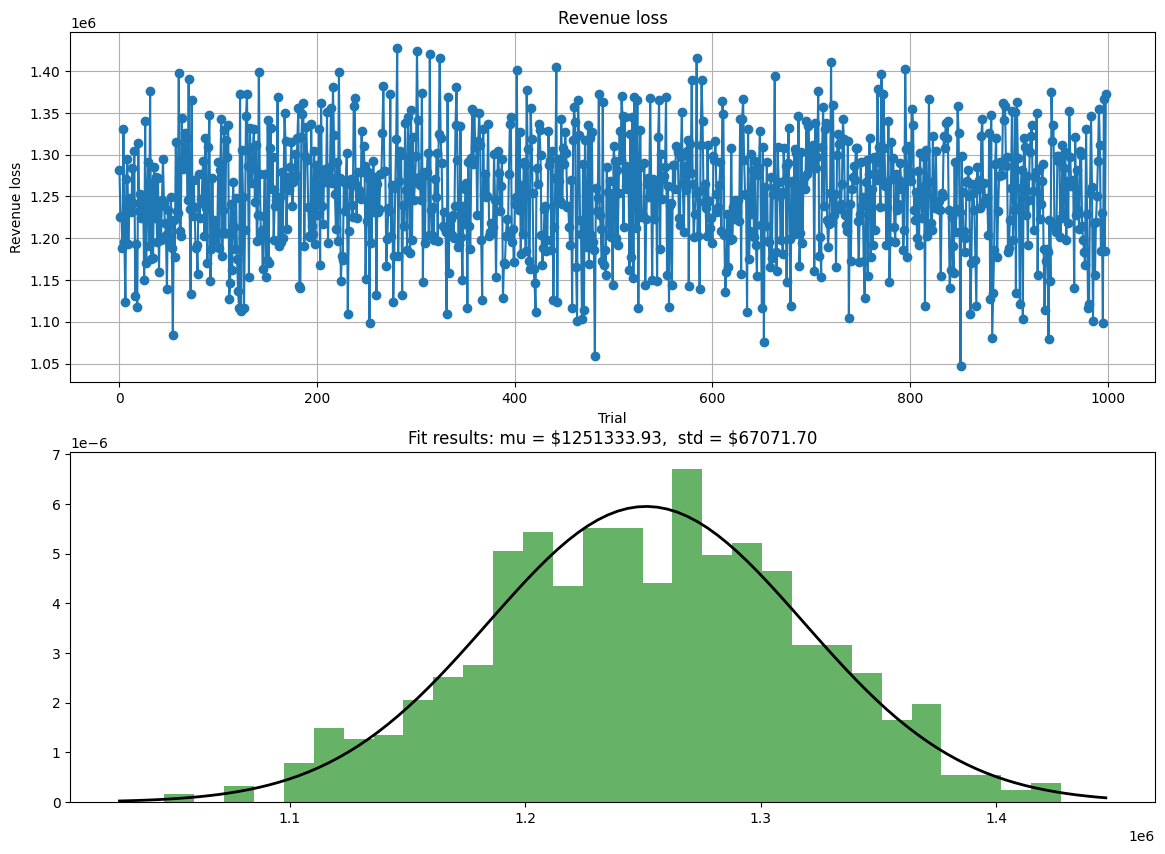

In [245]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
ax1.plot(revenue_loss, marker='o')
ax1.set_title('Revenue loss')
ax1.set_xlabel('Trial')
ax1.set_ylabel('Revenue loss')
ax1.grid(True)

data = np.array(revenue_loss)

# Fit a normal distribution to the data
mu, std = norm.fit(revenue_loss)

# Plot the histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = \$%.2f,  std = \$%.2f" % (mu, std)
plt.title(title)

plt.show()